# Get the vibe - Experimental Notebook

## Set up

### Imports

In [59]:
# General libraries
import numpy as np
import pandas as pd

# Image related
import matplotlib.pyplot as plt 
from matplotlib import image
from keras.preprocessing.image import load_img, img_to_array
import os

# CNN
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

# Confusion Matrix & Additional Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# Google Colab
from google.colab import drive 

#### Set up

##### Google Drive Imports 

In [2]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
image_df = pd.read_csv("drive/MyDrive/Data/NewAugmentedData3.csv")

##### Imports

##### Show Images

In [4]:
# Define formate
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

In [5]:
# Function showing picture
def show_image(index):
    """Shows the image and the emotion label of the index's instance."""
    image = aug_data.at[index, "pixels"].split(" ")
    image = np.reshape(image,(FER2013_WIDTH, FER2013_HEIGHT)).astype("float")
    print(Emotions[aug_data.at[index, "emotion"]])
    plt.imshow(image)

In [6]:
# Define Emotions
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  # indices 0 to 6

##### Normal Import

In [8]:
# Define Emotions
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  # indices 0 to 6

In [9]:
# Insert column emotions
image_df["emotion_new"] = image_df["emotion"].map({0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"})

## Preprosessing

### Exclude "disgust"

In [10]:
#image_df = image_df[image_df.emotion != 1]

### Training Data Split

In [11]:
train_set = image_df[(image_df.Usage == 'Training') | (image_df.Usage =='DataAug')] 
val_set = image_df[(image_df.Usage == 'PublicTest')]
test_set = image_df[(image_df.Usage == 'PrivateTest')] 

### Reshape X

In [12]:
# define x
X_train = np.array(list(map(str.split, train_set.pixels)), np.float32) 
X_val = np.array(list(map(str.split, val_set.pixels)), np.float32) 
X_test = np.array(list(map(str.split, test_set.pixels)), np.float32) 


X_train = X_train.reshape(X_train.shape[0], 48, 48, 1) 
X_val = X_val.reshape(X_val.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

### Scaling 

In [13]:
X_train = (X_train/255) -0.5
X_val = (X_val/255) - 0.5
X_test = (X_test/255) - 0.5

### One hot encode y

In [14]:
# define y
y_train = train_set["emotion"]
y_val = val_set["emotion"]
y_test = test_set["emotion"]

In [15]:
y_test

32286    0
32287    5
32288    6
32289    4
32290    2
        ..
35870    6
35871    3
35872    0
35873    3
35874    2
Name: emotion, Length: 3589, dtype: int64

In [16]:
# One Hot Encode our Target for TensorFlow processing
from tensorflow.keras.utils import to_categorical

y_cat_train = to_categorical(y_train, num_classes=7)
y_cat_test = to_categorical(y_test, num_classes=7)
y_cat_val = to_categorical(y_val, num_classes=7)

## General Evaluation Functions

In [17]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_title('Accurary')
    ax2.legend()
    return (ax1, ax2)

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
"""
Displays a confusion matrix 
"""

def confusio(X_test, y_test, model):
    
    predicted_probabilities = model.predict(X_test)
    def prediction_from_probabilities(predicted_probabilities):
        return np.argmax(predicted_probabilities)
    y_pred = np.apply_along_axis(prediction_from_probabilities, 
                                 1,                            
                                 predicted_probabilities)
    
    
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] 
    cm = confusion_matrix(y_test, y_pred)
    cm = cm / cm.astype(np.float).sum(axis=1) # convert into percentages
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = labels);
    fig, ax = plt.subplots(figsize=(10,10));
    title='Confusion matrix'
    plt.title(title)
    disp.plot(cmap = "PuRd", ax = ax);
    pass


In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
"""
Displays a confusion matrix 
"""

def confusio_abs(X_test, y_test, model):
    
    predicted_probabilities = model.predict(X_test)
    def prediction_from_probabilities(predicted_probabilities):
        return np.argmax(predicted_probabilities)
    y_pred = np.apply_along_axis(prediction_from_probabilities, 
                                 1,                            
                                 predicted_probabilities)
    
    
    labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'] 
    cm = confusion_matrix(y_test, y_pred)
    
    
    disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = labels);
    fig, ax = plt.subplots(figsize=(10,10));
    title='Confusion matrix'
    plt.title(title)
    disp.plot(cmap = "PuRd", ax = ax);
    pass

##  Model

### Cheeta model

#### Cheeta  model

In [46]:
# Define regularizer
reg_l2 = regularizers.L2(l2=0.01)

In [63]:
### 1. Architecture
model_insane = models.Sequential()

# Initial Layer
model_insane.add(layers.Conv2D(32, (3, 3), input_shape=(48, 48, 1),activation='relu'))
model_insane.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.25))

# 1. Hidden Layer
model_insane.add(layers.Conv2D(128, (5, 5), padding='same', activation='relu'))
BatchNormalization()
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.25))

# 2. Hidden Layer
model_insane.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu',kernel_regularizer=reg_l2))
BatchNormalization()
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.3))

# 3. Hidden Layer
model_insane.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu',kernel_regularizer=reg_l2))
BatchNormalization()
model_insane.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_insane.add(layers.Dropout(0.3))

# Flatten Layer
model_insane.add(layers.Flatten())
model_insane.add(layers.Dense(256, activation='relu'))
BatchNormalization()
model_insane.add(layers.Dropout(0.3))

model_insane.add(layers.Dense(512, activation='relu'))
BatchNormalization()
model_insane.add(layers.Dropout(0.3))

# Output Layer
model_insane.add(layers.Dense(7, activation='softmax'))

model_insane.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_41 (Conv2D)          (None, 46, 46, 32)        9248      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 23, 23, 32)       0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 23, 23, 128)       102528    
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 11, 11, 128)      0         
 g2D)                                                

In [64]:
#### 2. Compilation

#optimiser = tf.keras.optimizers.Adam(lr=0.0001)


model_insane.compile(loss='categorical_crossentropy',
            optimizer=Adam(lr=0.0001),
            metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [65]:
#### 3. Fit
es = EarlyStopping(patience=12, restore_best_weights=True,)

history = model_insane.fit(X_train, y_cat_train,
                    epochs=100,
                    batch_size=32, 
                    verbose=1,
                    use_multiprocessing = True,
                    validation_data=(X_val,y_cat_val),
                    callbacks=[es]) 

Epoch 1/150
1651/1651 [==============================] - 21s 12ms/step - loss: 2.1364 - accuracy: 0.3056 - val_loss: 1.9432 - val_accuracy: 0.2322
Epoch 2/150
1651/1651 [==============================] - 19s 11ms/step - loss: 1.3456 - accuracy: 0.5145 - val_loss: 1.8336 - val_accuracy: 0.2952
Epoch 3/150
1651/1651 [==============================] - 19s 11ms/step - loss: 1.1683 - accuracy: 0.5911 - val_loss: 1.7921 - val_accuracy: 0.3250
Epoch 4/150
1651/1651 [==============================] - 19s 11ms/step - loss: 1.0880 - accuracy: 0.6211 - val_loss: 1.7123 - val_accuracy: 0.3595
Epoch 5/150
1651/1651 [==============================] - 19s 11ms/step - loss: 1.0292 - accuracy: 0.6464 - val_loss: 1.6226 - val_accuracy: 0.4147
Epoch 6/150
1651/1651 [==============================] - 19s 11ms/step - loss: 0.9794 - accuracy: 0.6671 - val_loss: 1.5835 - val_accuracy: 0.4270
Epoch 7/150
1651/1651 [==============================] - 19s 11ms/step - loss: 0.9414 - accuracy: 0.6843 - val_loss: 1

In [66]:
# Safe model
import joblib
from datetime import datetime

today = datetime.today()
joblib.dump(model_insane, 'drive/MyDrive/models/model_'+str(today)+'.joblib')

INFO:tensorflow:Assets written to: ram://95beacf0-792d-4d27-81c2-8f0574073aae/assets


['drive/MyDrive/models/model_2022-03-12 23:00:51.870690.joblib']

#### Evaluation

In [67]:
# Evaluate model on the test data
print(model_insane.evaluate(X_test, y_cat_test, verbose=0))

[1.145105004310608, 0.6475341320037842]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f87e0194390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f87e0251fd0>)

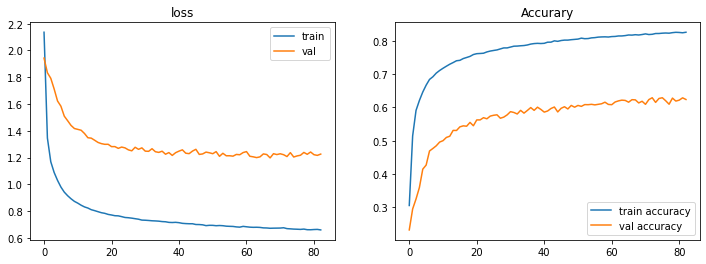

In [68]:
plot_history(history)

In [69]:
from sklearn.metrics import classification_report

labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
predicted_probabilities = model_insane.predict(X_test)
def prediction_from_probabilities(predicted_probabilities):
    return np.argmax(predicted_probabilities)
y_pred = np.apply_along_axis(prediction_from_probabilities, 
                             1,                            
                             predicted_probabilities)

print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

       Angry       0.58      0.57      0.57       491
     Disgust       0.63      0.53      0.57        55
        Fear       0.54      0.35      0.42       528
       Happy       0.82      0.87      0.85       879
         Sad       0.51      0.52      0.51       594
    Surprise       0.74      0.74      0.74       416
     Neutral       0.59      0.72      0.65       626

    accuracy                           0.65      3589
   macro avg       0.63      0.61      0.62      3589
weighted avg       0.64      0.65      0.64      3589



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


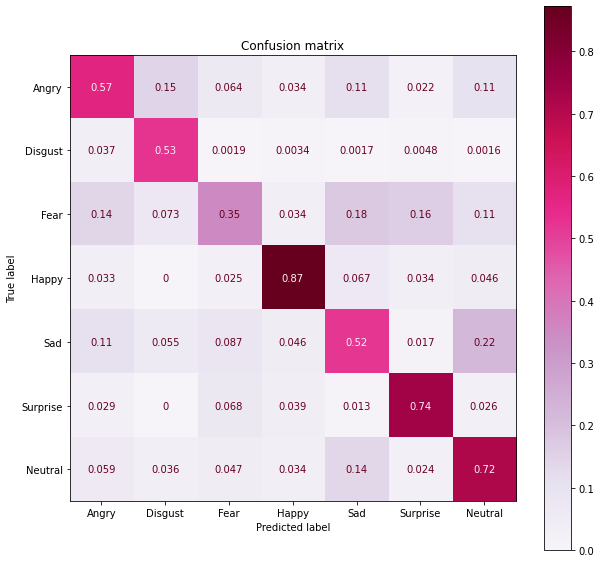

In [83]:
confusio(X_test, y_test, model_insane)

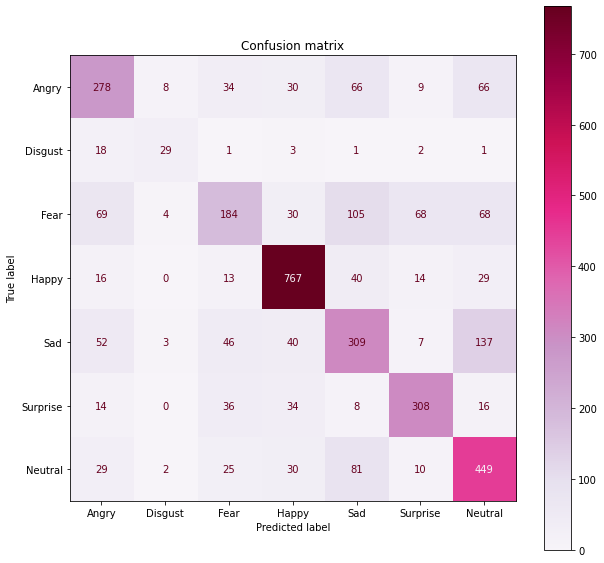

In [84]:
confusio_abs(X_test, y_test, model_insane)